# Auto Encoder for LHC Olympics

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
import colorsys
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import pandas as pd
#from pyjet import cluster,DTYPE_PTEPM
import random
import math


/tmpscratch/ktamenar/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
device

'cuda:0'

In [3]:
torch.cuda.set_device(device)
torch.cuda.empty_cache()

## Data loading and pre-processing 

In [4]:
events= pd.read_csv("events_rotated.csv",nrows=1000, header=None)
#print(np.shape(events))
events=events.iloc[:,:-1]
print(events.shape)
events.head(5)

(1000, 684)


,0,1,2,3,4,5,6,7,8,9,...,674,675,676,677,678,679,680,681,682,683
0,160.280,-0.775630,1.54283,147.447,-0.761960,1.53829,145.1770,-0.761662,1.53357,94.9798,...,4.77116,0,0.137383,4.77116,0,0.137383,4.77116,0,0.137383,4.77116
1,199.078,0.314598,4.98958,156.365,0.420856,4.66053,141.0500,0.347907,4.64931,101.6660,...,1.53656,0,-0.376553,1.53656,0,-0.376553,1.53656,0,-0.376553,1.53656
2,387.967,-1.057200,4.73939,264.843,-1.047750,4.72179,255.9740,-1.049300,4.74102,229.6310,...,1.54702,0,0.651014,1.54702,0,0.651014,1.54702,0,0.651014,1.54702
3,261.120,-0.242184,4.91415,210.262,-0.234154,4.95077,102.8820,-0.241660,4.96391,93.4942,...,1.33680,0,-0.434404,1.33680,0,-0.434404,1.33680,0,-0.434404,1.33680
4,263.943,-0.003251,1.50531,186.349,-0.002712,1.50625,86.6281,-0.667637,1.60293,80.5108,...,4.77547,0,-0.094544,4.77547,0,-0.094544,4.77547,0,-0.094544,4.77547


In [5]:
events_re = events.values.reshape(228000,3)
np.shape(events_re)
events_re = pd.DataFrame(events_re, columns = ["pT","eta","phi"])

# Map phi from [0,2Pi] -> [-Pi,Pi]

#events_re["phi"] = np.where(events_re["phi"] > math.pi, events_re["phi"] - 2*math.pi, events_re["phi"])

print("pT max = {}, min = {} ".format (events_re["pT"].max(), events_re["pT"].min()))
print("eta max = {}, min = {} ".format (events_re["eta"].max(), events_re["eta"].min()))
print("phi max = {}, min = {} ".format (events_re["phi"].max(), events_re["phi"].min()))
NPT=events_re["pT"].max()
NETA=events_re["eta"].max()
NPHI=events_re["phi"].max()

pT max = 1793.29, min = 0.0 
eta max = 2.60014, min = -2.41119 
phi max = 5.72618, min = 0.452764 


In [6]:
#Data Normalization [0,1]

#events_re["pT"] = events_re["pT"]/events_re["pT"].max()
#events_re["eta"] = (events_re["eta"] - events_re["eta"].min())/(events_re["eta"].max() - events_re["eta"].min())
#events_re["phi"] = (events_re["phi"] - events_re["phi"].min())/(events_re["phi"].max() - events_re["phi"].min())

#Data Normalization [-1,1] for all elements

events_re["pT"] = events_re["pT"]/events_re["pT"].max()
events_re["eta"] = events_re["eta"] / events_re["eta"].max()
events_re["phi"] = events_re["phi"] / events_re["phi"].max() 

events_re.head(5)

,pT,eta,phi
0,0.089378,-0.298303,0.269434
1,0.082222,-0.293046,0.268642
2,0.080956,-0.292931,0.267817
3,0.052964,-0.294466,0.268111
4,0.035399,-0.297411,0.271137


In [7]:
print("pT max = {}, min = {} ".format (events_re["pT"].max(), events_re["pT"].min()))
print("eta max = {}, min = {:.2f} ".format (events_re["eta"].max(), events_re["eta"].min()))
print("phi max = {}, min = {:.2f} ".format (events_re["phi"].max(), events_re["phi"].min()))

pT max = 1.0, min = 0.0 
eta max = 1.0, min = -0.93 
phi max = 1.0, min = 0.08 


In [8]:
events = events_re.values.reshape(1000,684) 

In [9]:
#Separates de events into test, validation and training

events_tra, events_val, events_tes = np.split(events, [int(.6*len(events)), int(.8*len(events))])

print(len(events_tra))
print(len(events_val))
print(len(events_tes))

600
200
200


## Model and training 

In [10]:
#Autoencoder example 

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        # encoder
        
        n1, n2, n3, n4, n5, n6 = 684, 550, 400, 250, 100, 20
        
        self.enc1 = nn.Linear(in_features= n1, out_features=n2)
        self.enc2 = nn.Linear(in_features=n2, out_features=n3)
        self.enc3 = nn.Linear(in_features=n3, out_features=n4)
        self.enc4 = nn.Linear(in_features=n4, out_features=n5)
        self.enc5 = nn.Linear(in_features=n5, out_features=n6)
        # decoder 
        self.dec1 = nn.Linear(in_features=n6, out_features=n5)
        self.dec2 = nn.Linear(in_features=n5, out_features=n4)
        self.dec3 = nn.Linear(in_features=n4, out_features=n3)
        self.dec4 = nn.Linear(in_features=n3, out_features=n2)
        self.dec5 = nn.Linear(in_features=n2, out_features= n1)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = self.dec5(x)
        return x
model = Autoencoder1()
#print(model)

In [11]:
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),
        lr = 1e-3,
        weight_decay = 1e-8)

criterion = nn.MSELoss()

epochs = 20
batch_size = 10


#Events for training set

#trainset = torch.tensor(events_tra.values)
trainset = torch.tensor(events_tra)
trainset=trainset.to(torch.float32)
#print(trainset.shape)


trainloader = DataLoader(
    dataset=trainset, 
    batch_size=batch_size,
    shuffle=True,
)

#Events for validation set

val_losses = []


valset = torch.tensor(events_val)
valset=valset.to(torch.float32)

valloader = DataLoader(
    dataset = valset, 
    batch_size = batch_size,
    shuffle = True,
)

#Events for test set

tes_losses = []

tesset = torch.tensor(events_tes)
tesset=valset.to(torch.float32)

tesloader = DataLoader(
    dataset = tesset, 
    batch_size = batch_size,
    shuffle = True,
)

print(trainloader)
print(len(trainloader))
print("********************************")
print(valloader)
print(len(valloader))
print("********************************")
print(tesloader)
print(len(tesloader))


60
********************************
20
********************************
20


In [12]:
yv, xv, xt, yt, train_losses = [],[],[],[],[]
early_stop = 5

def train(epoch):
    model.train()
    train_loss, val_loss, flag = 0, 0, 0
    
    for data in trainloader:
        optimizer.zero_grad()
        data = data.cuda() #input and target data 
        xt.append(data.cpu().detach().numpy())         
        y=model(data)  #output
        yt.append(y.cpu().detach().numpy())
        loss = criterion(y, data) #comparision between input and target data(output)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    
    print('====> Epoch: {} Average_training_loss: {:.6f}'.format(
        epoch, train_loss / len(trainloader)))
    
    train_losses.append(train_loss / len(trainloader))
    
 
    model.eval()
    for data in valloader:
        data = data.cuda()
        xv.append(data.cpu().detach().numpy())
        optimizer.zero_grad()
        y=model(data)
        yv.append(y.cpu().detach().numpy())
        loss = criterion(y, data)
        loss.backward()
        val_loss += loss.item()
        optimizer.step()
    
    print('====> Epoch: {} Average_training_loss_val: {:.6f}'.format(
        epoch, val_loss / len(valloader)))
    
    val_losses.append(val_loss / len(valloader))
    
    #Implementing Early stopping
    if val_loss > val_losses[-1]:
        flag += 1
        if flag == early_stop+1:
            raise Exception("STOPPING TRAINING EARLY AT EPOCH:{}".format(epoch))
    print('*********************************************************')


In [13]:
for epoch in range(1, epochs + 1):
    train(epoch)

#saving the model parameters of last epoch   
torch.save({'epoch':epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses, #losses from all epochs
            'val_loss': val_losses},
           '/scratch365/ktamenar/AE/model.pth')

====> Epoch: 1 Average_training_loss: 0.070214
====> Epoch: 1 Average_training_loss_val: 0.054648
*********************************************************
====> Epoch: 2 Average_training_loss: 0.056341
====> Epoch: 2 Average_training_loss_val: 0.044371
*********************************************************
====> Epoch: 3 Average_training_loss: 0.035521
====> Epoch: 3 Average_training_loss_val: 0.026957
*********************************************************
====> Epoch: 4 Average_training_loss: 0.027200
====> Epoch: 4 Average_training_loss_val: 0.017778
*********************************************************
====> Epoch: 5 Average_training_loss: 0.014734
====> Epoch: 5 Average_training_loss_val: 0.012808
*********************************************************
====> Epoch: 6 Average_training_loss: 0.012802
====> Epoch: 6 Average_training_loss_val: 0.012839
*********************************************************
====> Epoch: 7 Average_training_loss: 0.012257
====> Epoch: 7 Av

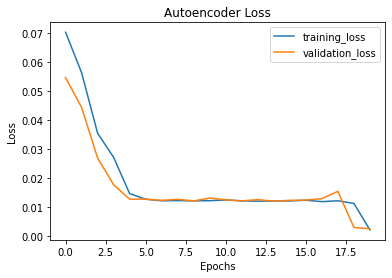

In [14]:
# Loss plot

plt.figure()
plt.plot(train_losses, alpha=1.0, linewidth=1.5, label="training_loss")
plt.plot(val_losses, alpha=1.0, linewidth=1.5, label="validation_loss")
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.legend(loc='upper right')
plt.savefig('Loss.png')

#fig.tight_layout()
#fig.savefig( "Loss.png", bbox_inches='tight' )

## Testing 

In [15]:
#Loading model parameters as check

#checkpoint = torch.load('/scratch365/ktamenar/AE/model.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#loaded_epoch = checkpoint['epoch']
#print("loaded epoch = ",loaded_epoch)
#loss_function = checkpoint['train_loss']
#print("loaded loss = ",loss_function)
#model_state = checkpoint['model_state_dict']
#print("'model_state_dict' = ",model_state)


In [16]:
model2 = Autoencoder1()
checkpoint = torch.load('/scratch365/ktamenar/AE/model.pth')
model2.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [17]:
#Testing

model2.cuda()
test_loss_per_epoch = 0.
input_list, output_list = np.zeros((1,684)), np.zeros((1,684))

for idx,event in enumerate(tesloader):
    
    event = event.cuda()
    reconstructed = model2.forward(event)
    test_loss = criterion(reconstructed, event)
    test_loss_per_epoch += test_loss.cpu().data.numpy().item()
    if idx < 20:
        print("Loss for this input: ",test_loss.cpu().data.numpy().item())
        input_list = np.vstack((input_list,(event.cpu().detach().numpy())))
        output_list = np.vstack((output_list,(reconstructed.cpu().detach().numpy())))

tes_losses.append(test_loss_per_epoch/int(tesset.shape[0]))
print("Test Loss: %f"%(test_loss_per_epoch/int(tesset.shape[0])))

np.savetxt("test_inputs.txt", input_list[1:])
np.savetxt("test_outputs.txt", output_list[1:])


Loss for this input:  0.0019644382409751415
Loss for this input:  0.0032348057720810175
Loss for this input:  0.0013629441382363439
Loss for this input:  0.00149588065687567
Loss for this input:  0.0017153226071968675
Loss for this input:  0.0014771971618756652
Loss for this input:  0.0025051769334822893
Loss for this input:  0.0012467597844079137
Loss for this input:  0.0017276100115850568
Loss for this input:  0.0020067456644028425
Loss for this input:  0.0019251459743827581
Loss for this input:  0.0015065304469317198
Loss for this input:  0.0013160365633666515
Loss for this input:  0.0016230795299634337
Loss for this input:  0.0010324587346985936
Loss for this input:  0.004164337180554867
Loss for this input:  0.002047142945230007
Loss for this input:  0.0021832266356796026
Loss for this input:  0.001699931686744094
Loss for this input:  0.0017835982143878937
Test Loss: 0.000190


# Reversing the normalization 

In [18]:
outputs = pd.read_csv("test_outputs.txt", sep=" ", header=None)
outputs_re = outputs.values.reshape(45600,3)
np.shape(outputs_re)
outputs_re = pd.DataFrame(outputs_re, columns = ["pT","eta","phi"])
outputs_re.head()

,pT,eta,phi
0,0.275560,0.293617,0.266081
1,0.135867,0.326065,0.257326
2,0.097534,0.312879,0.255978
3,0.054540,0.303984,0.264055
4,0.037100,0.303870,0.250993


In [19]:
outputs_re["pT"] = outputs_re["pT"] * NPT
outputs_re["eta"] = outputs_re["eta"] * NETA
outputs_re["phi"] = outputs_re["phi"] * NPHI
outputs_re.head()

,pT,eta,phi
0,494.159405,0.763447,1.523630
1,243.648558,0.847816,1.473496
2,174.906535,0.813530,1.465774
3,97.805450,0.790401,1.512024
4,66.530542,0.790105,1.437233


In [20]:
outputs_fj = outputs_re.values.reshape(200,684)
np.savetxt("OUTPUTS_FJ.csv", outputs_fj, delimiter=" ")

# Visualizing input vs output

In [21]:
def plot_heatmap(input, output, label):

    input = input.reshape(228,3)
    output = output.reshape(228,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    surf = ax.bar3d(input['phi'],input['eta'],input['pT'],0.05,0.05,0.05,color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    surf2 = ax.bar3d(output['phi'],output['eta'],output['pT'],0.05,0.05,0.05,shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [22]:
def plot_heatmap_blue(input, output, label):

    input = input.reshape(228,3)
    output = output.reshape(228,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    #surf = ax.bar3d(input['eta'],input['phi'],5,0.2,0.2,input['pT'],color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    surf2 = ax.bar3d(output['phi'],output['eta'],output['pT'],0.05,0.05,0.05,shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [23]:
def plot_heatmap_green(input, output, label):

    input = input.reshape(228,3)
    output = output.reshape(228,3)

    input = pd.DataFrame(input, columns = ["pT","eta","phi"])
    input = input.loc[~(input==0).all(axis=1)]
    output = pd.DataFrame(output, columns = ["pT","eta","phi"])
    output = output.loc[~(output==0).all(axis=1)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    surf = ax.bar3d(input['phi'],input['eta'],input['pT'],0.05,0.05,0.05,color='g',shade=True)
    in_proxy = plt.Rectangle((0, 0), 1, 1, fc="g")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("phi")
    ax.set_ylabel("eta")
    ax.set_zlabel("pT")
    #surf2 = ax.bar3d(output['eta'],output['phi'],5,0.2,0.2,output['pT'],shade=True)
    out_proxy = plt.Rectangle((0, 0), 1, 1, fc="b")
    ax.legend([in_proxy,out_proxy],['input event','AE output event'])
    plt.show()
    plt.close()

In [33]:
#output_list = output_list[1:]
#input_list = input_list[1:]

n=12
ot = output_list[n]
print(ot.shape)
im = input_list[n]
print(im.shape)

(684,)
(684,)


/srv/ipykernel_22/2567666978.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


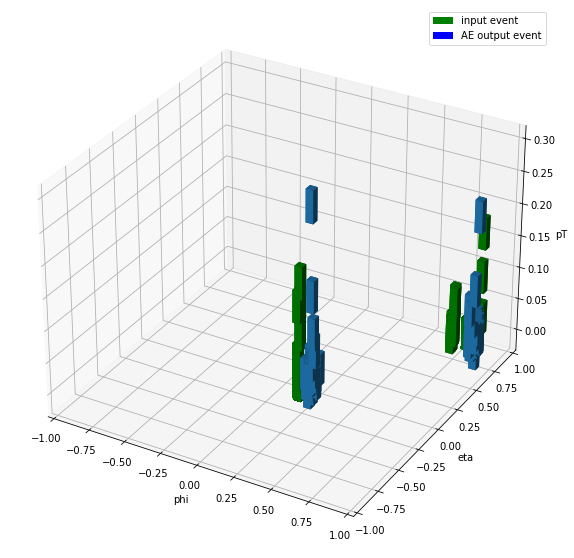

In [34]:
plot_heatmap(im,ot,"all")

/srv/ipykernel_22/622417047.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


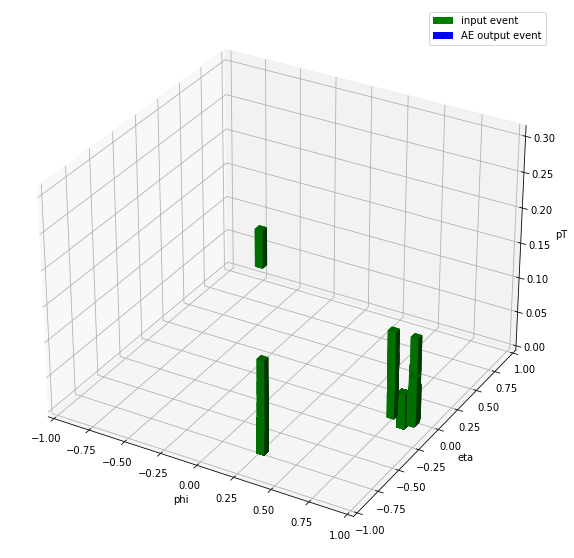

In [26]:
plot_heatmap_green(im,ot,"input")

/srv/ipykernel_22/1260706165.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


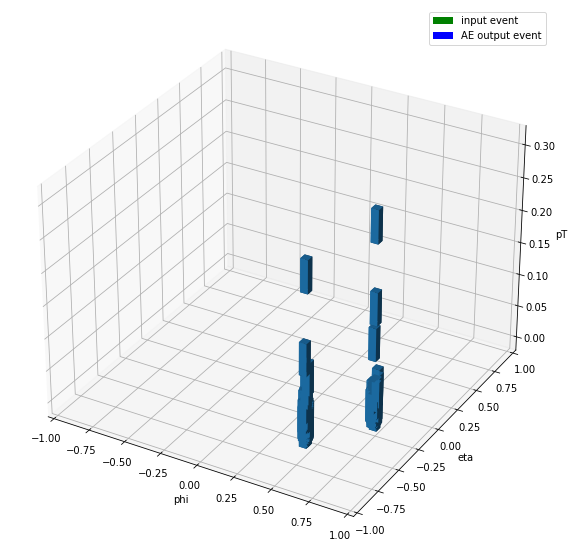

In [27]:
plot_heatmap_blue(im,ot,"output")

Text(0, 0.5, 'output')

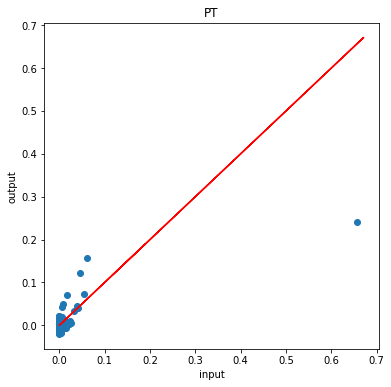

In [58]:
diag= np.random.uniform(low=0, high=xns["pT"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["pT"],yns["pT"])
plt.plot(diag,diag, color="red")
plt.title("PT")
plt.xlabel("input")
plt.ylabel("output")
#ax.plot(ident,ident)

Text(0, 0.5, 'output')

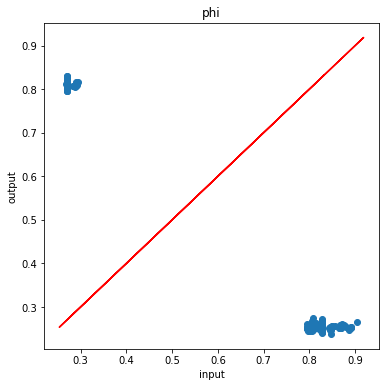

In [59]:
diag= np.random.uniform(low=xns["phi"].min()-.015, high=xns["phi"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["phi"],yns["phi"])
plt.plot(diag,diag, color="red")
plt.title("phi")
plt.xlabel("input")
plt.ylabel("output")

Text(0, 0.5, 'output')

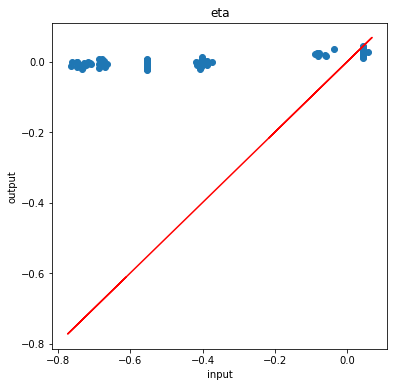

In [60]:
diag= np.random.uniform(low=xns["eta"].min()-.015, high=xns["eta"].max()+.015, size=(500,))
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xns["eta"],yns["eta"])
plt.plot(diag,diag, color="red")
plt.title("eta")
plt.xlabel("input")
plt.ylabel("output")